In [ ]:
import shutil
shutil.rmtree("nas_demo/mnist_nas")  # Delete previous tuner results

In [3]:
# Install dependencies if not already installed
# pip install tensorflow keras-tuner

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# =========================
# 1. Load and preprocess data
# =========================
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Flatten images to 1D vectors and normalize to [0,1]
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.0

# =========================
# 2. Define the model-building function
# =========================
# This function defines the search space for NAS
def build_model(hp):
    """
    hp: HyperParameters object used by Keras Tuner to sample values
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(28*28,)))  # Input layer
    
    # -------------------------
    # Search Space
    # -------------------------
    # Tune number of hidden layers: 1 to 3
    for i in range(hp.Int("num_layers", 1, 3)):
        # Tune number of units in each layer: 32, 64, ..., 256
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        # Tune activation function: relu or tanh
        activation = hp.Choice("activation", ["relu", "tanh"])
        model.add(layers.Dense(units=units, activation=activation))
    
    # Output layer (fixed, 10 classes)
    model.add(layers.Dense(10, activation="softmax"))
    
    # -------------------------
    # Compile the model
    # -------------------------
    # Tune learning rate of Adam optimizer
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# =========================
# 3. Define the search strategy
# =========================

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs=5,       # total epochs cap
    factor=3,           # halving rate
    directory="nas_demo",
    project_name="mnist_nas",
    overwrite=True,      # False to resume
    hyperband_iterations=1
)

early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

# =========================
# 4. Run the search (NAS)
# =========================
# Evaluation strategy: Split 20% of training data for validation
tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early],
)

# =========================
# 5. Retrieve the best model and hyperparameters
# =========================
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# =========================
# 6. Evaluate on test data
# =========================
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print("Best Hyperparameters:", best_hyperparameters.values)
print("Test Accuracy:", test_acc)


Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.9709166884422302

Best val_accuracy So Far: 0.9750000238418579
Total elapsed time: 00h 02m 25s
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9785 - loss: 0.0742    
Best Hyperparameters: {'num_layers': 2, 'units_0': 256, 'activation': 'relu', 'learning_rate': 0.0013066377367869325, 'units_1': 128, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001', 'units_2': 160}
Test Accuracy: 0.9785000085830688


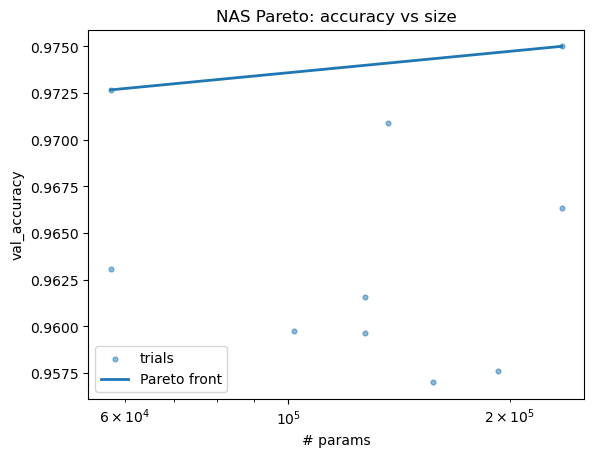

In [5]:
# collect trials
trials = tuner.oracle.get_best_trials(num_trials=50)

pts = []
for t in trials:
    hp = t.hyperparameters
    m = tuner.hypermodel.build(hp)
    acc = t.metrics.get_last_value("val_accuracy")
    pts.append((m.count_params(), acc))

# compute Pareto front (maximize acc, minimize params)
pts.sort(key=lambda x: x[0])  # sort by params
front = []
best_acc = -1.0
for p, a in pts:
    if a > best_acc:
        front.append((p, a))
        best_acc = a

import matplotlib.pyplot as plt
P, A = zip(*pts)
FP, FA = zip(*front)

plt.figure()
plt.scatter(P, A, s=12, alpha=0.5, label="trials")
plt.plot(FP, FA, linewidth=2, label="Pareto front")
plt.xscale("log")
plt.xlabel("# params")
plt.ylabel("val_accuracy")
plt.title("NAS Pareto: accuracy vs size")
plt.legend()
plt.show()

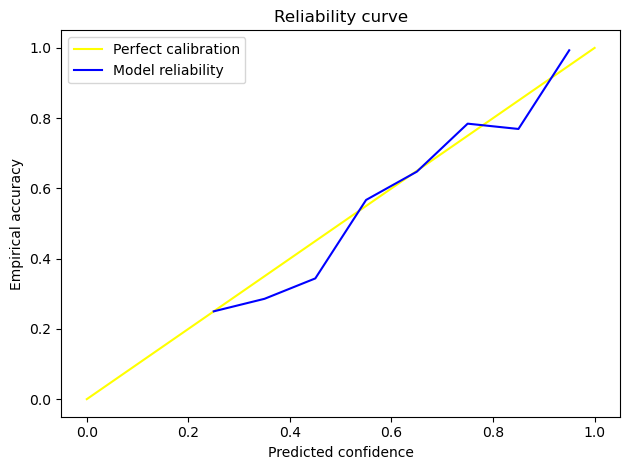

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recompute predictions to avoid stale vars
probs = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

conf = probs.max(axis=1)
correct = (y_pred == y_test).astype(int)

bins = np.linspace(0.0, 1.0, 11)
df = pd.DataFrame({"conf": conf, "correct": correct})
df["bin"] = pd.cut(df["conf"], bins, include_lowest=True)
calib = df.groupby("bin", observed=True)["correct"].agg(["mean", "count"]).reset_index()

centers = np.array([(b.left + b.right) / 2 for b in calib["bin"]])

plt.figure()
plt.plot([0, 1], [0, 1], label="Perfect calibration", color="yellow")
plt.plot(centers, calib["mean"], label="Model reliability", color="blue")
plt.xlabel("Predicted confidence")
plt.ylabel("Empirical accuracy")
plt.title("Reliability curve")
plt.legend()
plt.tight_layout()
plt.show()

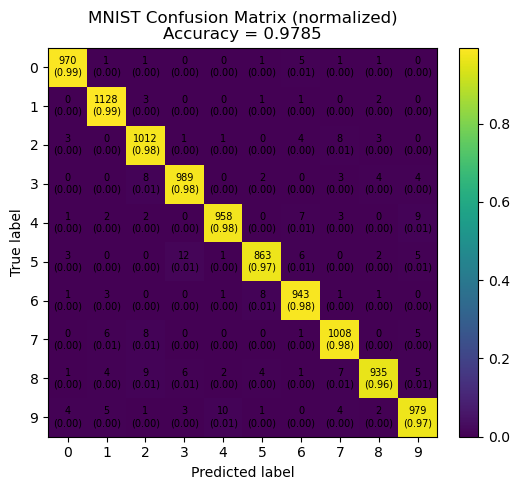

              precision    recall  f1-score   support

           0      0.987     0.990     0.988       980
           1      0.982     0.994     0.988      1135
           2      0.969     0.981     0.975      1032
           3      0.978     0.979     0.979      1010
           4      0.985     0.976     0.980       982
           5      0.981     0.967     0.974       892
           6      0.974     0.984     0.979       958
           7      0.974     0.981     0.977      1028
           8      0.984     0.960     0.972       974
           9      0.972     0.970     0.971      1009

    accuracy                          0.979     10000
   macro avg      0.979     0.978     0.978     10000
weighted avg      0.979     0.979     0.978     10000



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# Predict
y_prob = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=range(10), zero_division=0)
report = classification_report(y_test, y_pred, digits=3)

# Confusion matrices
cm = confusion_matrix(y_test, y_pred, labels=range(10))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

classes = [str(i) for i in range(10)]

# Plot: normalized CM with counts and rates
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title(f"MNIST Confusion Matrix (normalized)\nAccuracy = {acc:.4f}")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate each cell with "count (rate)"
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        rate = cm_norm[i, j]
        ax.text(j, i, f"{cm[i,j]}\n({rate:.2f})",
                ha="center", va="center",
                fontsize=7)

plt.tight_layout()
plt.show()

"""
# Bar chart: per-class precision/recall/F1
x = np.arange(10)
width = 0.25
plt.figure(figsize=(7,3))
plt.bar(x - width, pr, width, label="Precision")
plt.bar(x,        rc, width, label="Recall")
plt.bar(x + width, f1, width, label="F1")
plt.xticks(x, classes)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Per-class Precision / Recall / F1")
plt.legend()
plt.tight_layout()
plt.show()
"""
# Text report
print(report)